- To download this notebook, click the download icon in the toolbar above and select the .ipynb format.  
- For any questions or comments, please open an issue on the [c4dynamics issues page](https://github.com/C4dynamics/C4dynamics/issues).  


# Ballistic Coefficient Estimation using Extended Kalman Filter 

An estimatation of the ballistic coefficient of a target in a free fall tracked by a noisy altimeter radar.

## Priliminary Remarks 

1. The mathematical background required for understanding the Extended Kalman Filter and the form of implementation used by `c4dynamics` is found in [the introduction page to the filters module documentary](https://c4dynamics.github.io/C4dynamics/api/Filters.html#extended-kalman-filter-ekf). 

2. The `ekf` class API is found [here](https://c4dynamics.github.io/C4dynamics/api/filters.ekf.html#c4dynamics.filters.ekf.ekf). 

3. Zarchan `[1]` provides a great deal of detail about this example. Additional sources can be found in `[2]`.



<div style='text-align: center;'>
  <img src='ekf.drawio.png' alt='alt text'>
  <figcaption>Figure 1: Flowchart of the simulation. The target dynamics uses as a reference to the Kalman prediction and the radar measurements correct the estimates. When the loop is over, all the data is transmitted outside to plot results. </figcaption>
</div>

## Extended Kalman Filter (EKF)

The basics of EKF were covered in [the filters introduction](https://c4dynamics.github.io/C4dynamics/api/Filters.html#extended-kalman-filter-ekf) to provide the background material required for the understanding and developing state estimation for nonlinear systems. Here is a brief recap:

- A linear Kalman filter ([kalman](https://c4dynamics.github.io/C4dynamics/api/filters.kalman.html)) should be the first choice when designing a state observer. However, when a nominal trajectory cannot be found, the solution is to linearize the system at each cycle about the current estimated state (that is what the EKF does).

- The linearization is required for the iterative solution to the algebraic Riccati equation. The Riccati equation is using to calculate Kalman gain and the optimal covariance matrix.

- Similarly to the linear Kalman filter, a good approach to design an extended Kalman filter is to separate it to two steps: predict and update (correct).

- The calculation of the state vector 
 both in the predict step (projection in time using the process equations) and in the update step (correction using the measure equations) does not have to use the approximated linear expressions and can use the exact nonlinear equations.


## Setup 

In [6]:
import c4dynamics as c4d
from scipy.integrate import odeint
import numpy as np 

In [7]:
dt, tf = .01, 30
tspan = np.arange(0, tf + dt, dt) 
dtsensor = 0.05  
rho0, k = 0.0034, 22000 

## Dynamics `[1]`

The estimation of the ballistic coefficient requires simulating the target. This involves determining parameters and modeling its dynamics, i.e. the equations of motion.  

When a ballistic target re-enters the atmosphere after having traveled a long distance, 
its speed is high and the remaining time to ground impact is relatively short.

The small distances traveled by ballistic targets after they re-enter the atmosphere
enable to accurately model these threats using the flat-Earth, constant gravity
approximation. 

In this model, only drag and gravity act on the ballistic target. 

<div style='text-align: center;'>
  <img src='ekf.balance.png' alt='alt text' style="max-width: 100%; height: auto; width: 150px;">
  <figcaption>Figure 2: A radar tracking the distance of a ballistic target in the altitude direction</figcaption>
</div>

The acceleration components of the ballistic target in the
altitude direction can either be expressed in terms of the target weight
$W$, reference area $s_{ref}$, zero lift drag $C_{d_0}$, and gravity $g$, 
or more simply in terms of the ballistic coefficient $\beta$ according to 

$$
\frac{dv}{dt} = \frac{F_{drag}}{m} - g = \frac{Q⋅s_{ref}⋅C_{d_0}⋅g}{W} - g = \frac{Q⋅g}{\beta} - g
$$

Where $Q$ is the dynamic pressure = $0.5⋅\rho⋅v^2$, with air density $\rho$ given by the approximated term:
$$\rho = 0.0034 ⋅ e^{-z / 22000}$$

Since the acceleration equation is in inertial frame it can be integrated directly to yield velocity and position.



Let the state vector include the target altitude, vertical velocity, and ballistic coefficient: 

$$
x = \begin{bmatrix}
z \\
v_z \\
\beta 
\end{bmatrix}
$$

The above acceleration term leads to the set of ordinary differential equations describing the system: 

$$\dot{z} = v_z$$  

$$\dot{v}_z = {\rho_0 \cdot e^{-z / k} \cdot v_z^2 \cdot g \over 2 \cdot \beta} - g$$  

$$\dot{\beta} = \omega_{\beta}$$  

With output measure: 

$$y = z + \nu_k$$


Where:  
- $z$ is the target altitude ($ft$)  
- $v_z$ is the target vertical velocity ($ft/s$)  
- $\beta$ is the target ballistic coefficient ($lb/ft^2$)  
- $y$ is the system output   
- $\omega_{\beta} \sim (0, 300)$, the uncertainty in the ballistic coefficient behavior  
- $\nu_k \sim (0, 500)$, the measurement noise   
- $g = 32.2 ft/s^2$, the gravitational constant  
- $\rho_{0} = 0.0034$  
- $k = 22,000$   


In the form of `ODE` function, these equations are given in the ballistic function: 

In [8]:
def ballistics(y, t):
  
  z, vz, beta = y

  z_dot     = vz
  vz_dot    = rho0 * np.exp(-z / k) * vz**2 * c4d.g_fts2 / 2 / beta - c4d.g_fts2
  beta_dot  = 0

  return [z_dot, vz_dot, beta_dot]

`g_fts2` is the [gravity constant](https://c4dynamics.github.io/C4dynamics/api/utils.const.html) in foot per seconds squared. 

## $1^{st}$ Case: Ideal Radar

Let's start with a simple measure of the target position where no errors or uncertainties are present. 
The state variables are taken from the ground truth simulation without running an estimation. 

### Setup & Initial Conditions

In [9]:
tgt = c4d.state(z = 100000, vz = -6000, beta = 500)
altmtr = c4d.sensors.radar(isideal = True, dt = dt)

The target is implemented by a [state object](https://c4dynamics.github.io/C4dynamics/api/states.state.html) with three variables: altitude, vertical velocity, and ballistic coefficient.  
The [radar](https://c4dynamics.github.io/C4dynamics/api/sensors.radar.html) is taken from the scientific library of c4dynamics, particularly, the seekers module. The introudced parameters indicate the required errors model (*ideal case*) and the samples rate ($10ms$). 

### Main Loop

The main loop in the ideal case does three things: 
1. Stores the current state
2. Integrates the system equations of motion
3. Samples the radar 

In [10]:
for t in tspan:
  tgt.store(t)
  tgt.X = odeint(ballistics, tgt.X, [t, t + dt])[-1]
  _, _, z = altmtr.measure(tgt, t = t, store = True)

### Plotting

Let's write a plotting function to draw the results in the ideal case as well as in later cases. 

The parameters of the function `drawekf()` enable to control the elements of the components to draw:  

- `ekf`: estimated object  
- `trueobj`: ground truth reference to the estimation  
- `measure`: the raw samples of the sensor  
- `std`: the square root of the covariance matrix $P$, representing one standard deviation of the estimation error  

Each subplot calls `plotdefaults()` from c4dynamics [utils](https://c4dynamics.github.io/C4dynamics/api/generated/utils/c4dynamics.utils.plottools.plotdefaults.html) to set default properties for an axis. 



In [11]:
from matplotlib import pyplot as plt  
plt.style.use('dark_background')  

def drawekf(ekf = None, trueobj = None, measures = None, std = False, title = '', txtcaption = None): 

  fig, ax = plt.subplots(1, 3, dpi = 200, figsize = (9, 3) 
                              , gridspec_kw = {'left': .15, 'right': .95
                                                , 'top': .80, 'bottom': .15
                                                  , 'hspace': 0.5, 'wspace': 0.4}) 

  fig.suptitle('                ' + title, fontsize = 14, fontname = 'Times New Roman')
  plt.subplots_adjust(top = 0.95) 


  ''' altitude '''

  if trueobj: 
    ax[0].plot(*trueobj.data('z'), 'm', linewidth = 1.2, label = 'true') 
  
  if measures: 
    ax[0].plot(*measures.data('range'), '.c', markersize = 1, label = 'altmeter')

  if ekf:
    ax[0].plot(*ekf.data('z'), linewidth = 1, color = 'y', label = 'ekf')

  if std: 
    x = ekf.data('z')[1]
    t_sig, x_sig = ekf.data('P00')
    # ±std 
    ax[0].plot(t_sig, x + np.sqrt(x_sig.squeeze()), linewidth = 1, color = 'w', label = 'std') # np.array(v.color) / 255)
    ax[0].plot(t_sig, x - np.sqrt(x_sig.squeeze()), linewidth = 1, color = 'w') # np.array(v.color) / 255)
 
  c4d.plotdefaults(ax[0], 'Altitude', 'Time [s]', 'ft', 10)
  ax[0].legend(fontsize = 'xx-small', facecolor = None, framealpha = .5)  
  

  ''' velocity '''

  if trueobj: 
    ax[1].plot(*trueobj.data('vz'), 'm', linewidth = 1.2, label = 'true') 

  if ekf:
    ax[1].plot(*ekf.data('vz'), linewidth = 1, color = 'y', label = 'ekf')

  if std: 
    x = ekf.data('vz')[1]
    t_sig, x_sig = ekf.data('P11') 
    # ±std 
    ax[1].plot(t_sig, (x + np.sqrt(x_sig.squeeze())), linewidth = 1, color = 'w', label = 'std') # np.array(v.color) / 255)
    ax[1].plot(t_sig, (x - np.sqrt(x_sig.squeeze())), linewidth = 1, color = 'w') # np.array(v.color) / 255)

  c4d.plotdefaults(ax[1], 'Velocity', 'Time [s]', 'ft/s', 10)


  ''' ballistic coefficient '''

  if trueobj: 
    ax[2].plot(*trueobj.data('beta'), 'm', linewidth = 1.2, label = 'true') # label = r'$\gamma$') #'\\gamma') # 

  if ekf:
    ax[2].plot(*ekf.data('beta'), linewidth = 1, color = 'y', label = 'ekf')

  if std: 
    x = ekf.data('beta')[1]
    t_sig, x_sig = ekf.data('P22')
    # ±std 
    ax[2].plot(t_sig, (x + np.sqrt(x_sig.squeeze())), linewidth = 1, color = 'w', label = 'std') # np.array(v.color) / 255)
    ax[2].plot(t_sig, (x - np.sqrt(x_sig.squeeze())), linewidth = 1, color = 'w') # np.array(v.color) / 255)

  c4d.plotdefaults(ax[2], 'Beta', 'Time [s]', 'lb/ft^2', 10)


  if txtcaption: 
    fig.add_artist(plt.Line2D([0.15, .85], [-0.05, -0.05], transform = fig.transFigure, color = "red", linewidth = .5, linestyle = "--",))
    plt.figtext(0.5, -0.15, txtcaption, wrap = True, horizontalalignment = 'center', fontsize = 10);

  return ax 


Now we can call `drawekf()` to plot the results of the ideal case: 

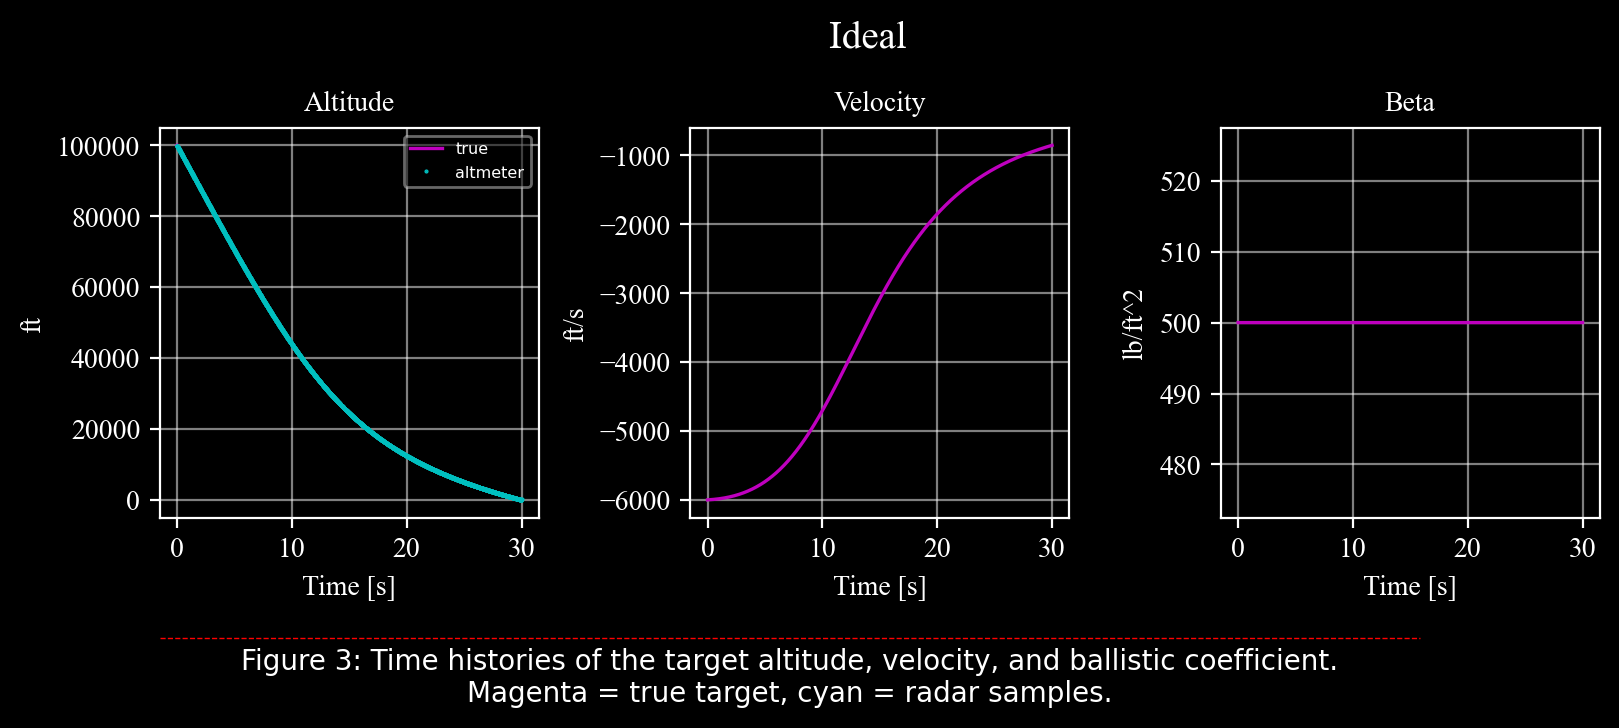

In [12]:
drawekf(trueobj = tgt, measures = altmtr, title = 'Ideal', txtcaption = "Figure 3: Time histories of the target altitude, velocity, and ballistic coefficient.\nMagenta = true target, cyan = radar samples.");

The magenta lines represent the true target properties while the cyan dots stand for the radar samples (the radar measures only the position). 
The ideal nature of the system is manifested by the exact location of the samples on the true position. 

## $2^{nd}$ Case: Noisy Radar

Before running the filter, let's ovserve the radar measurements in the presence of realistic parameters. 

The parameter $\nu = \sqrt{500}$ ($\nu$ is `nu`) represents one standard deviation of the noise, i.e. the radar noise is a white noise with mean $0$ and standard deviation $\sqrt{500}$. 

In addition, the sample rate is changed from the previous $10ms$ to a lower rate of $50ms$. 

### Setup & Initial Conditions

In [13]:
nu = np.sqrt(500) 
tgt = c4d.state(z = 100000, vz = -6000, beta = 500)
altmtr = c4d.sensors.radar(rng_noise_std = nu, dt = dtsensor)

### Main Loop

In [14]:
for t in tspan:
  tgt.store(t)
  tgt.X = odeint(ballistics, tgt.X, [t, t + dt])[-1]
  altmtr.measure(tgt, t = t, store = True)

### Results

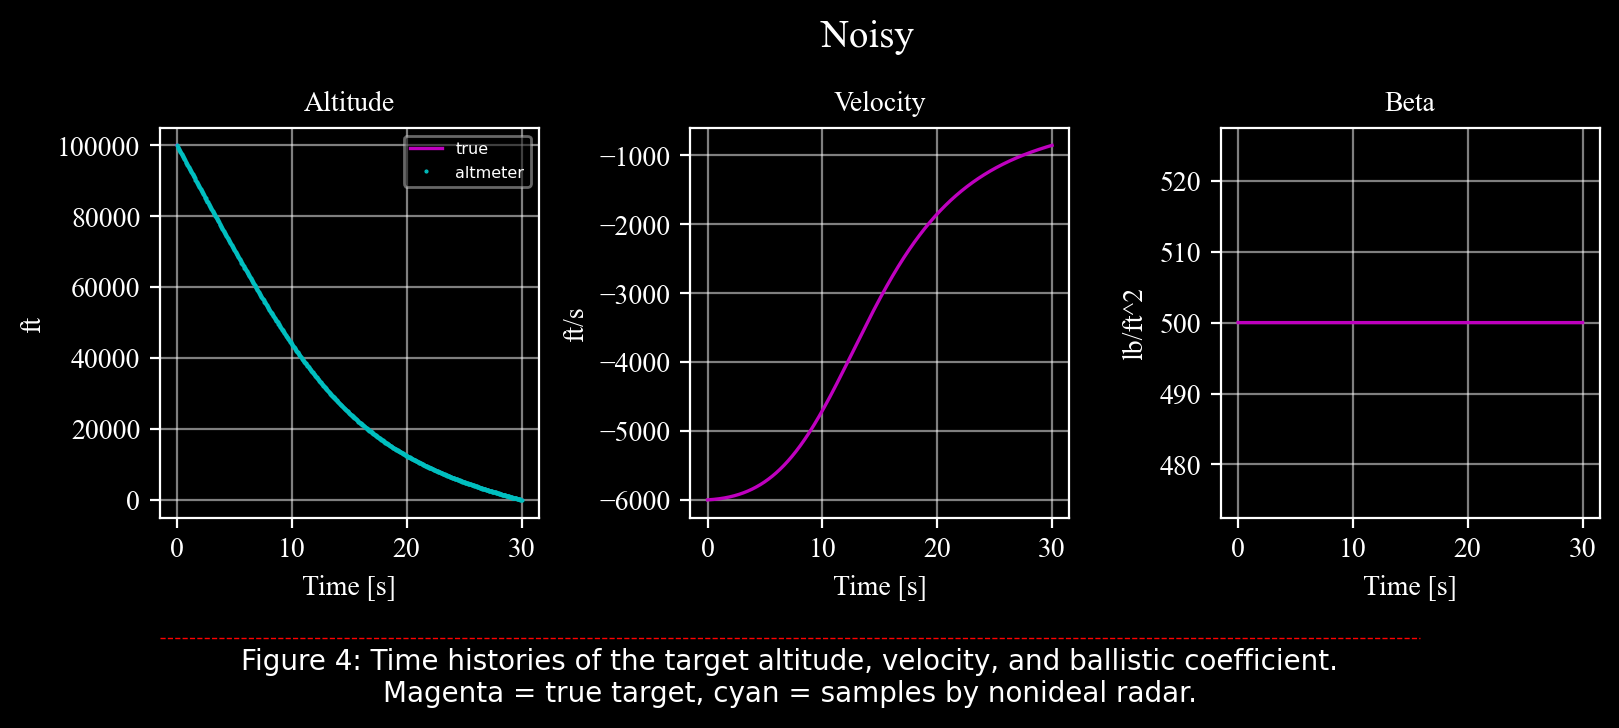

In [15]:
ax = drawekf(trueobj = tgt, measures = altmtr, title = 'Noisy', txtcaption = "Figure 4: Time histories of the target altitude, velocity, and ballistic coefficient.\nMagenta = true target, cyan = samples by nonideal radar.")

To observe the effect of the radar's realistic parameters, we need to focus on a small range of the altitude axis:

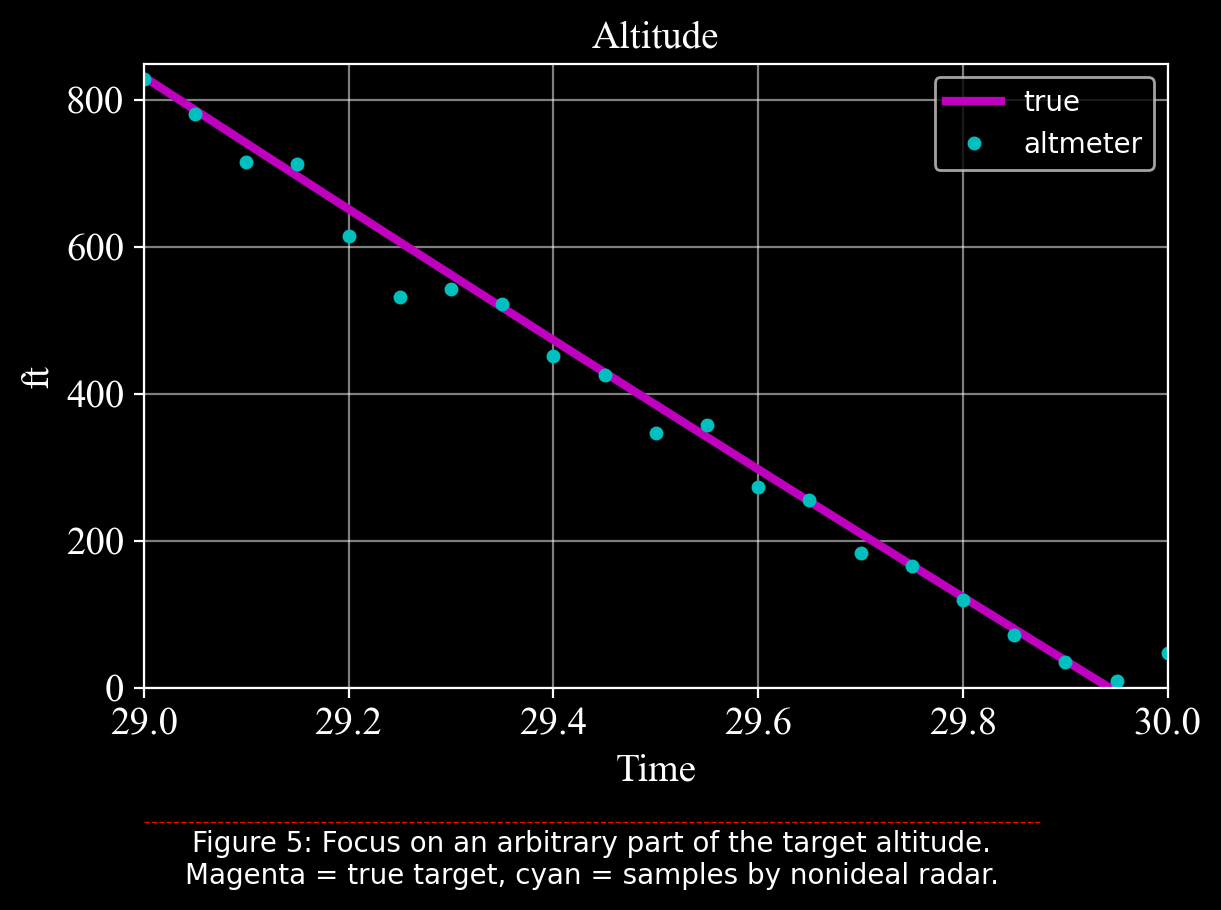

In [16]:
_, ax = plt.subplots(1, 1, dpi = 200, gridspec_kw = {'left': .15, 'right': .95, 'top': .80, 'bottom': .15}) 

ax.plot(*tgt.data('z'), 'm', linewidth = 3, label = 'true') 
ax.plot(*altmtr.data('range'), '.c', markersize = 8, label = 'altmeter') 
ax.axis((29, 30, 0, 850))
c4d.plotdefaults(ax, 'Altitude', 'Time', 'ft', 14)
ax.legend()

plt.gcf().add_artist(plt.Line2D([0.15, .85], [0.01, 0.01], transform = plt.gcf().transFigure, color = "red", linewidth = .5, linestyle = "--",))
plt.figtext(0.5, -0.05, "Figure 5: Focus on an arbitrary part of the target altitude.\n"
            "Magenta = true target, cyan = samples by nonideal radar."
                , wrap = True, horizontalalignment = 'center', fontsize = 10);

It is now evident that measurement errors can reach values as high as tens of feet, as predicted by a standard deviation of $\sqrt{500} ≈ 22$ ft.  
Another property observable in Figure 5 is the radar's operation rate, which captures 20 samples per second, corresponding to `dt = 50ms`. 

## $3^{rd}$ Case: Filterring 

Let us examine the capability of the `ekf` to estimate the system state, including the ballistic coefficient $\beta$. 

First, consider the following key points: 

1. In our problem, only the process equations are nonlinear, but the measurement equations are linear (the radar actually measures the altitude directly). 

2. The covariance matrices $Q$ and $R$ which represent the uncertainties in the process and the measurement respectively, are time invariant. 

Consequently, initializing and operating the filter involves the following steps: 

- Initialize the filter with initial conditions, covariance matrices $Q$ and $R$, and the measurement matrix $H$.  
- Find expression to the process equations Jacobian matrix.    
- Run the main loop:
- Before each call to `predict()`, evaluate the linearized process using the Jacobian matrix.
- Correct the estimate with the radar measurements.  

### Initial Conditions 

Since the initial conditions are not precisely known, let us define the following errors: 

In [17]:
zerr = 25       # initial error in position  
vzerr = -150      # initial error in velocity  
betaerr = 300       # initial error in ballistic coefficient 

### System Matrices 

The process equations are nonlinear, so there is no constant matrix $F$ to represent them. This matrix must be re-evaluated before each call to `predict()`, as discussed below.  
However, the radar directly measures the target's altitude, so the measurement matrix is simply:


$$
  H = \begin{bmatrix}
        1 & 0 & 0 
      \end{bmatrix}  
$$              


In [18]:
H = [1, 0, 0]

The covariance matrix $P$ is evaluated by the iterative solution of the algebraic Riccati equation. However, its initial condition must represent the errors of the state variables.  
We can use the errors that defined earlier to initialize the covariane matrix: 

In [19]:
P0 = np.diag([nu**2, vzerr**2, betaerr**2])

### Noise Covariances (Q, R) 

The uncertainty in the process model is associated with the ballistic coefficient.  
Given in terms of 
the spectral density of a continuous system, 
the standard deviation of the ballistic coefficient noise 
is $\omega_{\beta} = \sqrt{\beta_{err} \cdot t_f}$, where 
$\beta_{err}$ is the initial error in the ballistic coefficient 
and 
$t_f$ is the target flight time. 

The measurement noise is characterized by $\nu = \sqrt{500}$:


In [20]:
R = nu**2 / dt
Q = np.diag([0, 0, betaerr**2 / tf * dt])   

### Setup

Now that we have defined the initial conditions and the system matrices, we can proceed to setup an Extended Kalman filter.  
The initialization of an `ekf` object begins with a dictionary $X$ containing the state variables and their initial conditions.  
Then, with a diagonal matrix of initial state variances $P$.  
Finally, it requires the constant system matrices, which in this case include all matrices except the process matrix. 

In [21]:
tgt = c4d.state(z = 100000, vz = -6000, beta = 500)
altmtr = c4d.sensors.radar(rng_noise_std = nu, dt = dtsensor) 

''' Extended Kalman filter initialization '''
ekf = c4d.filters.ekf(X = {'z': tgt.z + zerr, 'vz': tgt.vz + vzerr
                                       , 'beta': tgt.beta + betaerr}
                                           , P0 = P0, H = H, Q = Q, R = R) 

### Main Loop 

Since the process is nonlinear (which is the primary reason for EKF over a linear Kalman), the process equations must be linearized in each cycle around the current estimated state. To do that, we need to find an analytic expression of the nonlinear equations Jacobian, which happens to be: 


$$
  A = \begin{bmatrix}
        0 & 1 & 0 \\
          -\rho \cdot g \cdot v_z^2 / (44000 \cdot \beta) 
          & \rho \cdot g \cdot v_z / \beta
          & -\rho \cdot g \cdot v_z^2 \cdot / (2 \cdot \beta^2) \\ 
            0 & 0 & 0
      \end{bmatrix}  
$$



Where:

$$
  \rho = \rho_0 \cdot e^{-z / k}
$$


Finally, the discrete form of the process matrix is:

$$
F = I + A \cdot dt
$$

Where $I$ is the identity matrix and $dt$ is the discretization step size. 

Note that although the process is linearized, the nonlinear equations are still passed to the `predict()` function to integrate the derivatives using their exact expressions.   

All the steps described earlier appear in the following main loop with a comment line entitling every section: 

In [22]:
for t in tspan:
  # store states
  tgt.store(t)
  ekf.store(t)
  # target motion simulation  
  tgt.X = odeint(ballistics, tgt.X, [t, t + dt])[-1]
  # process linearization 
  rhoexp = rho0 * np.exp(-ekf.z / k) * c4d.g_fts2 * ekf.vz / ekf.beta
  fx = [ekf.vz, rhoexp * ekf.vz / 2 - c4d.g_fts2, 0]
  f2i = rhoexp * np.array([-ekf.vz / 2 / k, 1, -ekf.vz / 2 / ekf.beta])
  # discretization 
  F = np.array([[0, 1, 0], f2i, [0, 0, 0]]) * dt + np.eye(3)
  # ekf predict 
  ekf.predict(F = F, fx = fx, dt = dt)
  # take a measure 
  _, _, Z = altmtr.measure(tgt, t = t, store = True)
  if Z is not None:  
    # ekf update 
    ekf.update(Z)

### Results 

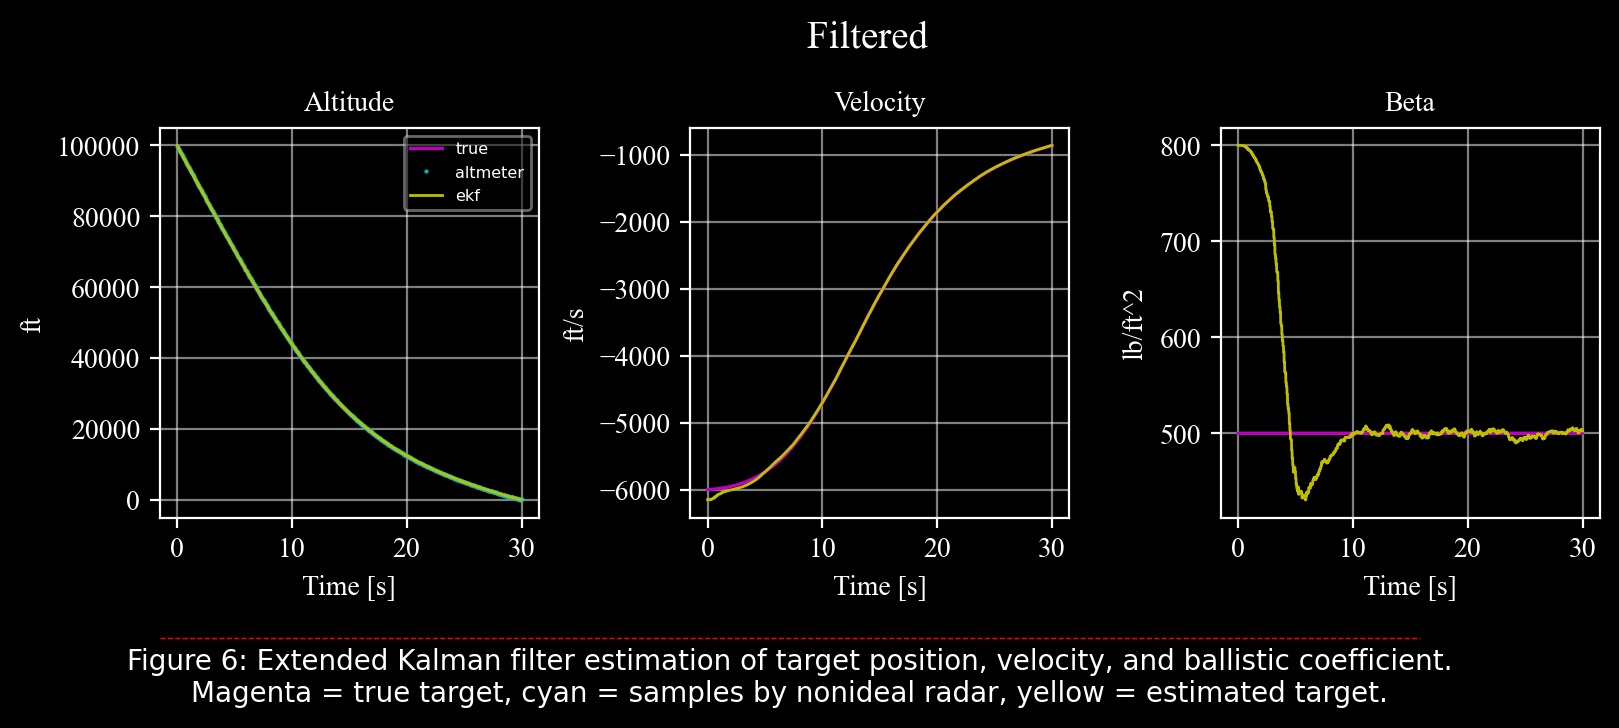

In [23]:
drawekf(trueobj = tgt, measures = altmtr, ekf =  ekf, title = 'Filtered', txtcaption = "Figure 6: Extended Kalman filter estimation of target position, velocity, and ballistic coefficient.\nMagenta = true target, cyan = samples by nonideal radar, yellow = estimated target.");

The position and velocity estimates are straightforward. The velocity estimation starts with an error of $−150 ft/s$, as defined, and quickly converges to the true target velocity. The ballistic coefficient estimation begins with a relatively large error but converges to the true value after an initial overshoot.  

The improvement at later times corresponds to a descent in altitude. It occurs at approximately $60 kft$ altitude, below which the extended Kalman filter provides an excellent estimate of the target’s ballistic coefficient. For initial altitudes higher than $100 kft$, however, the EKF may struggle to achieve similar results. The ballistic coefficient is not observable, from position measurements alone, at high altitudes due to the absence of significant drag forces.  

Another scenario where the filter may fail is when there is a relatively large error in the initial conditions. For example, we set $\beta_0 = 800$, which is $300$ higher than the true coefficient value.  
However, for errors as large as $1000$, the filter ultimately fails to estimate the state in time.  
Unlike the linear Kalman filter, the performance of the extended Kalman filter is highly dependent on the initial conditions.  

To address these sensitivities, we introduced a nonzero process noise in the coefficient variable of the process noise matrix ($Q$). This adjustment adds flexibility to the filter dynamics and improves robustness.  
The effect of this process noise can be observed in the following figure, where the estimated error (white lines) remains high and does not converge as a function of time.  


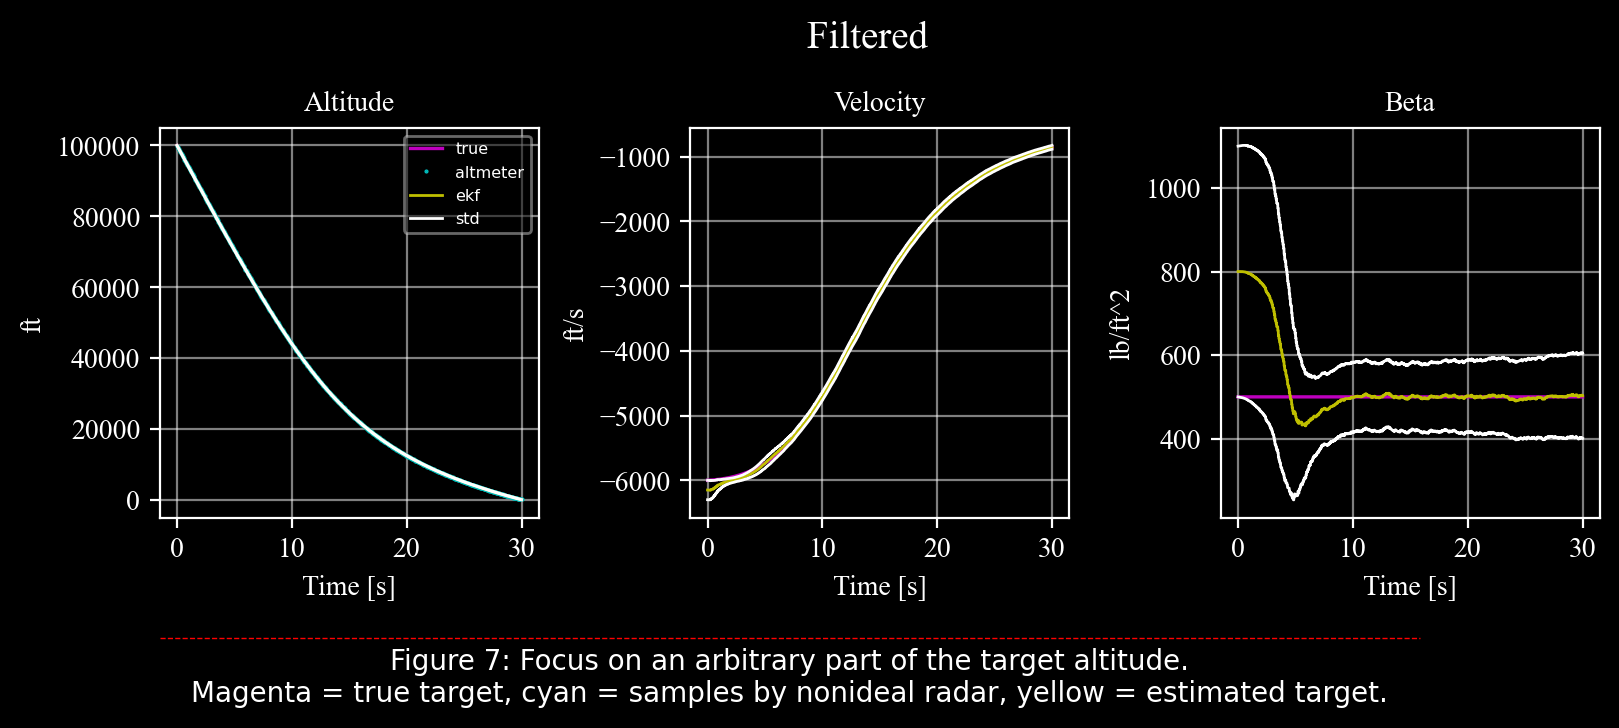

In [24]:
drawekf(trueobj = tgt, measures = altmtr, ekf =  ekf, title = 'Filtered', std = True, txtcaption = "Figure 7: Focus on an arbitrary part of the target altitude.\nMagenta = true target, cyan = samples by nonideal radar, yellow = estimated target.");

`Figure 7` compares the actual error (the difference between the true target value — magenta — and the estimated target value — yellow) with the theoretical predictions of the covariance matrix (white).  

Here, we see that the actual error agrees with the theoretical predictions; that is, the actual errors do not exceed the bounds predicted by the system covariance ($P$).  

However, one drawback of the extended Kalman filter is the potential discrepancy between the actual errors and the covariance predictions.  

This highlights a key limitation: the filter may not detect when it is failing.  
Thus, while the covariance matrix is essential for computing the Kalman gain, its theoretical predictions are not always reliable for assessing filter performance.  


# Conclusion

This notebook highlighted the successful estimation of the ballistic coefficient, a critical parameter in the target's aerodynamics, using the Extended Kalman Filter (EKF). 

The EKF's implementation within the c4dynamics framework proved effective, leveraging its capabilities for flexible state management, system modeling, and process linearization. 

The results emphasize the importance of a structured approach to filter design, particularly in understanding the underlying system dynamics and refining noise parameters. 



A few steps to consider when designing a Kalman filter: 

- Spend some time understanding the dynamics. It's the basis of great filtering. 
- If the system is nonlinear, identify the nonlinearity; is it in the process? in the measurement? both? 
- Always prioriorotize linear Kalman. If possible, find a nominal trajectory to linearize the system about.
- The major time-consuming activity is researching the balance between the noise matrices $Q$ and $R$ $→$ Plan your time in advance.
- Use a framework that provides you with the most flexibility and control.
- Make fun!


# References 

`[1]` Zarchan, Paul, Tactical and Strategic Missile Guidance, American Institute of Aeronautics and Astronautics, 1981.

`[2]` Simon, Dan, Optimal State Estimation: Kalman, H Infinity, and Nonlinear Approaches, Hoboken: Wiley, 2006.
